In [8]:
import numpy as np
import scipy.constants as sciconst
import matplotlib.pyplot as plt
import navicsim as navs

## Simulation constants 

In [9]:
#code chip rate, sample rate and sample period
#refer to navicsim.py for all function detials
codeFreqBasis = 1.023e6
sampleRate = 10*codeFreqBasis
samplePeriod = 1/sampleRate

#simulation duration, steps at which values are recorded(here for every 1ms)
simDuration = 1
timeStep = 1e-3
numSteps = round(simDuration/timeStep)
samplePerStep = int(timeStep/samplePeriod)
codeTable = navs.genNavicCaTable(sampleRate)
codeTableSampCnt = len(codeTable)
#satId is the satellite ID for multiple satellites to track
satId = np.array([5, 7, 3, 1])
numChannel = len(satId)

In [10]:
c = sciconst.speed_of_light
fe = 1176.45e6;              
Dt = 12;                     
DtLin = 10*np.log10(Dt)
Dr = 4;                      
DrLin = 10*np.log10(Dr)
Pt = 44.8;                   
k = sciconst.Boltzmann;  
T = 300;                     
rxBW = 24e6;                 
Nr = k*T*rxBW;               

In [11]:
#simulation constants for tracking loop
PLLIntegrationTime = 1e-3
PLLNoiseBandwidth = 90 # In Hz
FLLNoiseBandwidth = 4  # In Hz
DLLNoiseBandwidth = 1  # In Hz

## Channel configuration

In [12]:
#frequrency shift to be applied to the signal
fShift = np.array([3589, 2256, 1596, 2568])
channelpfo = navs.PhaseFrequencyOffset(sampleRate)
#sigDelay is the delay in samples in channels
sigDelay = np.array([300.34, 587.21, 425.89, 312.88])
dynamicDelayRange = 50
staticDelay = np.round(sigDelay - dynamicDelayRange)
channelstatd = navs.IntegerDelay(staticDelay)
channelvard = navs.FractionalDelay(4, 65535)

sqrtPr = np.sqrt(Pt*DtLin*DrLin)*(1/(4*np.pi*(fe+fShift)*sigDelay*samplePeriod))

## Run Simulation

In [13]:
datagen = navs.NavicDataGen(50, sampleRate, numChannel)
modulator = navs.NavicL5sModulator(sampleRate)

rms = lambda x: np.sqrt(np.mean(np.abs(x)**2, axis=0)) 

for istep in range(numSteps):
    
    # Baseband modulation
    navdata = datagen.GenerateBits(timeStep)
    iqsig = modulator.Modulate(navdata, codeTable[:, satId-1])

    # Doppler shift
    doppsig = channelpfo.Offset(iqsig, fShift)

    # Delay
    staticDelayedSignal = channelstatd.Delay(doppsig)
    leftoutDelay = sigDelay - staticDelay
    delayedSig = channelvard.Delay(staticDelayedSignal, leftoutDelay)

    # Power scaling
    scaledSig = navs.PowerScale(delayedSig, sqrtPr)

    # Add signals from each channel
    resultsig = np.sum(scaledSig, axis=1)

    # Generate noise
    noisesig = (np.random.normal(scale=Nr**0.5, size=(samplePerStep, )) + 1j*np.random.normal(scale=Nr**0.5, size=(samplePerStep, )))/2**0.5

    # Add thermal noise to composite signal
    rxwaveform = resultsig + noisesig

    # Scale received signal to have unit power
    waveform = rxwaveform/rms(rxwaveform)  

    # Perform acquisition once from cold-start
    if istep == 0:

        # Acqusition doppler search space
        fMin = -5000
        fMax = 5000
        fStep = 500
        fSearch = np.arange(fMin, fMax+fStep, fStep)

        tracker = []
        satVis = 0
        
        # Perform acquisition for each satellite
        for prnId in satId:
            status, codePhase, doppler = navs.navic_pcps_acquisition(
                                            waveform, 
                                            codeTable[np.arange(0, samplePerStep)%codeTableSampCnt, prnId-1], 
                                            sampleRate, 
                                            fSearch
                                        )   
            delaySamp = codePhase
            codePhase = (codePhase % codeTableSampCnt)/(sampleRate/codeFreqBasis)

            print(f"Acquisition results for PRN ID {prnId}\n Status:{status} Doppler:{doppler} Delay/Code-Phase:{delaySamp}/{codePhase}")

            # If a satellite is visible, initialize tracking loop
            if(status == True):
                satVis += 1

                tracker.append(navs.NavicTracker())
                tracker[-1].SampleRate = sampleRate
                tracker[-1].CenterFrequency = 0
                tracker[-1].PLLNoiseBandwidth = PLLNoiseBandwidth
                tracker[-1].FLLNoiseBandwidth = FLLNoiseBandwidth
                tracker[-1].DLLNoiseBandwidth = DLLNoiseBandwidth
                tracker[-1].PLLIntegrationTime = round(PLLIntegrationTime*1e3)
                tracker[-1].PRNID = prnId
                tracker[-1].InitialDopplerShift = doppler
                tracker[-1].InitialCodePhaseOffset = codePhase
                tracker[-1].setupImpl()
                tracker[-1].resetImpl()

            trackDataShape = (numSteps*round(PLLIntegrationTime*1e3), satVis)
            y = np.empty(trackDataShape, dtype=np.complex_)
            fqyerr = np.empty(trackDataShape)
            fqynco = np.empty(trackDataShape)
            pherr = np.empty(trackDataShape)
            phnco = np.empty(trackDataShape)
            delayerr = np.empty(trackDataShape)
            delaynco = np.empty(trackDataShape)

    # Perform tracking for visible satellites
    for i in range(satVis):
      y[istep, i], fqyerr[istep, i], fqynco[istep, i], pherr[istep, i], phnco[istep, i], delayerr[istep, i], delaynco[istep, i] = tracker[i].stepImpl(waveform)

Acquisition results for PRN ID 5
 Status:True Doppler:3500 Delay/Code-Phase:300/30.0
Acquisition results for PRN ID 7
 Status:True Doppler:2500 Delay/Code-Phase:587/58.7
Acquisition results for PRN ID 3
 Status:True Doppler:1500 Delay/Code-Phase:426/42.6
Acquisition results for PRN ID 1
 Status:True Doppler:2500 Delay/Code-Phase:313/31.3


## Tracking Results

Tracking results for PRN ID:5
Transmitted Bits:
 [0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 0.]
Received bits:
 [1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 1.]
Received bits inverted:
 [0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1.
 0. 0.]


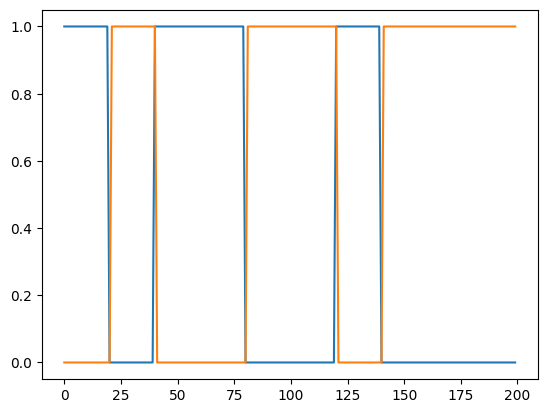

In [14]:
resultId = tracker[0].PRNID
satIdx = list(satId).index(resultId)
print(f"Tracking results for PRN ID:{resultId}")
print("Transmitted Bits:\n",datagen.GetBitStream()[:-1, satIdx])

mapbit = lambda y: np.piecewise(np.imag(y), [np.imag(y) < 0, np.imag(y) >= 0], [0, 1])
mapbitinv = lambda y: np.piecewise(np.imag(y), [np.imag(y) < 0, np.imag(y) >= 0], [1, 0])

print("Received bits:\n", mapbit(y[:, satIdx])[::20])
print("Received bits inverted:\n", mapbitinv(y[:, satIdx])[::20])

plt.plot(np.repeat(datagen.GetBitStream()[:-1, satIdx], 20)[800:])
plt.plot(mapbit(y[:, satIdx])[800:])
plt.show()